<a href="https://colab.research.google.com/github/LCaravaggio/politext/blob/main/LASSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
base=pd.read_csv('/content/drive/MyDrive/base_formateada.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-1-9f4a60c4adea>:4: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  base=pd.read_csv('/content/drive/MyDrive/base_formateada.csv')


In [2]:
import pickle

with open('/content/drive/MyDrive/vocabulary.voc', 'rb') as f:
    inter = pickle.load(f)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(2,2) ,vocabulary=inter)
matrix = cv.fit_transform(base['tokens'])

# LASSO

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from numpy import argsort

n=20
macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=50, solver='liblinear')
X_train, X_test, y_train, y_test = train_test_split(base.loc[:, base.columns != 'party'], base['party'], test_size=0.33, random_state=42)
train_matrix = cv.fit_transform(X_train['tokens'])
test_matrix = cv.transform(X_test['tokens'])  
lr.fit(train_matrix,y_train)
predictions = lr.predict(test_matrix )
macro.append(f1_score(predictions,y_test, average='macro'))
weighted.append(f1_score(predictions,y_test, average='weighted'))

In [7]:
lasso=pd.DataFrame()
lasso['negativos']=cv.get_feature_names_out()[argsort(lr.coef_[0])[:20]]
lasso['positivos']=cv.get_feature_names_out()[argsort(lr.coef_[0])[-20:]]

In [8]:
lasso.to_csv('lasso.csv')

# LASSO por legislatura

In [9]:
# Relevancia de bigramas en la predicción por legislatura
tabla=[]
legislaturas=['I', 'II', 'III', 'IV', 'V', 'VI', 'VII','VIII', 'IX', 'X', 'XI', 'XII','XIII']
n=20

macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=50, solver='liblinear')

lasso=pd.DataFrame()

for x in legislaturas: 
  base_year=base[base.legislatura==x]
  X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
  train_matrix = cv.fit_transform(X_train['tokens'])
  test_matrix = cv.transform(X_test['tokens'])  
  lr.fit(train_matrix,y_train)
  predictions = lr.predict(test_matrix )
  macro.append(f1_score(predictions,y_test, average='macro'))
  weighted.append(f1_score(predictions,y_test, average='weighted'))
  s=lr.coef_[0]
  lasso[f"Legislatura: {x} - neg"] = cv.get_feature_names_out()[argsort(s)[:n]]
  lasso[f"Legislatura: {x} - pos"] = cv.get_feature_names_out()[argsort(s)[-n:]]

In [10]:
lasso.to_csv('lasso_por_legislatura.csv')

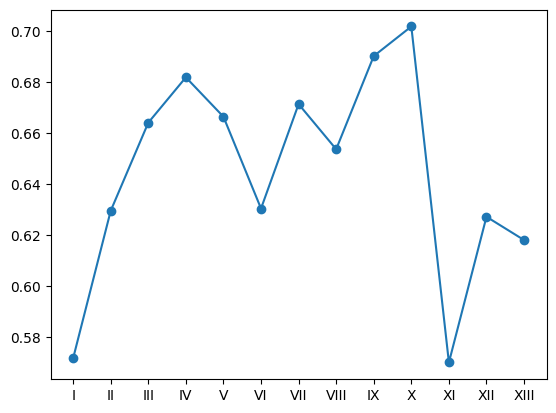

In [11]:
import matplotlib.pyplot as plt
plt.plot(legislaturas, macro, marker='o')
plt.savefig('lasso_por_legislatura.png')

# LASSO por año

In [12]:
base.fecha=pd.to_datetime(base.fecha, infer_datetime_format=True)

In [14]:
# Relevancia de bigramas en la predicción por año
macro=[]
weighted=[]

nombres=cv.get_feature_names_out()

n = 20
lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')


lasso=pd.DataFrame()

for x in range (1979, 2020): 
  base_year=base[pd.DatetimeIndex(base.fecha).year==x]
  X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
  train_matrix = cv.fit_transform(X_train['tokens'])
  test_matrix = cv.transform(X_test['tokens'])  
  lr.fit(train_matrix,y_train)
  predictions = lr.predict(test_matrix )
  macro.append(f1_score(predictions,y_test, average='macro'))
  weighted.append(f1_score(predictions,y_test, average='weighted'))
  s = lr.coef_[0]
  lasso[f"Año: {x} - neg"] = cv.get_feature_names_out()[argsort(s)[:n]]
  lasso[f"Año: {x} - pos"] = cv.get_feature_names_out()[argsort(s)[-n:]]

In [15]:
lasso.to_csv('lasso_por_año.csv')

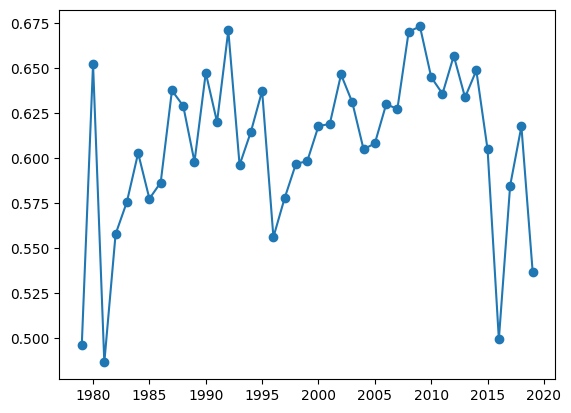

In [16]:
import matplotlib.pyplot as plt
plt.plot(range(1979,2020), macro, marker='o')
plt.savefig('lasso_por_año.png')

# LASSO por Semana

In [17]:
len((pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).unique())

1164

In [18]:
base['semana']=pd.Series(pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).values


In [21]:
# Esta celda tarda 40 minutos en correr
macro=[]
weighted=[]
n = 20
lasso=pd.DataFrame()

coeffs = []

for x in (pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).unique(): 
    base_semana = base[base['semana'] == x]
    X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
    train_matrix = cv.fit_transform(X_train['tokens'])
    test_matrix = cv.transform(X_test['tokens'])  
    lr.fit(train_matrix,y_train)
    predictions = lr.predict(test_matrix )
    macro.append(f1_score(predictions,y_test, average='macro'))
    weighted.append(f1_score(predictions,y_test, average='weighted'))
    s = lr.coef_[0]
    neg = cv.get_feature_names_out()[argsort(s)[:n]]
    pos = cv.get_feature_names_out()[argsort(s)[-n:]]
    coeffs.append(pd.DataFrame({'Semana': x, 'neg': neg, 'pos': pos}))
    
lasso = pd.concat(coeffs, axis=0, ignore_index=True)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [22]:
lasso.to_csv('lasso_por_semana.csv')

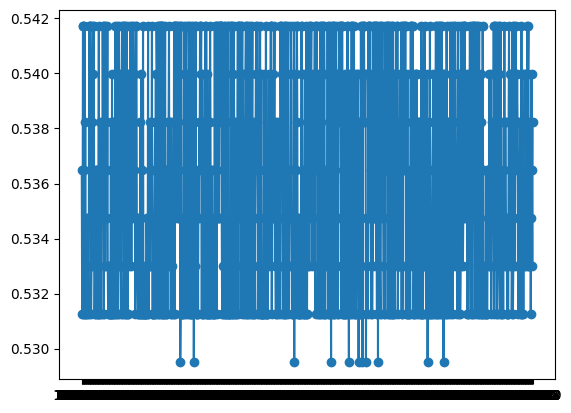

In [23]:
plt.plot((pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).unique(), macro, marker='o')
plt.savefig('lasso_por_semana.png')